In [1]:
import sys
sys.path.append(r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\DATA ANALYSIS\UTILS')
import drive

In [2]:
folder_id = '19ApmRMhBMmQ7gT2i8akhViuKDyhP3QML'

In [3]:
svc = drive.authenticate()

In [4]:
files = drive.list_files_in_folder(svc, folder_id, max_files=5)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

Decompressing file into memory...


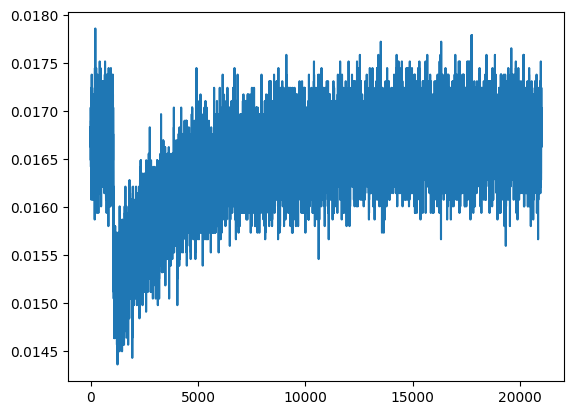

Decompressing file into memory...


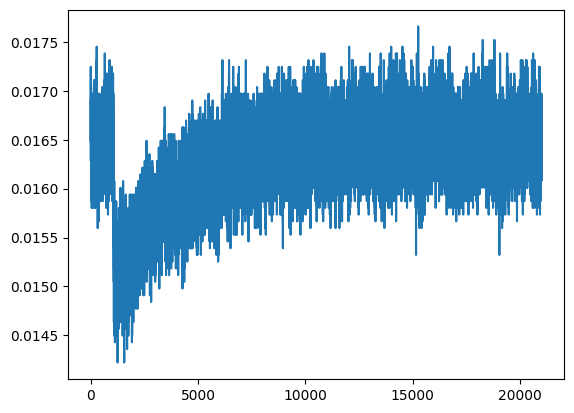

Decompressing file into memory...


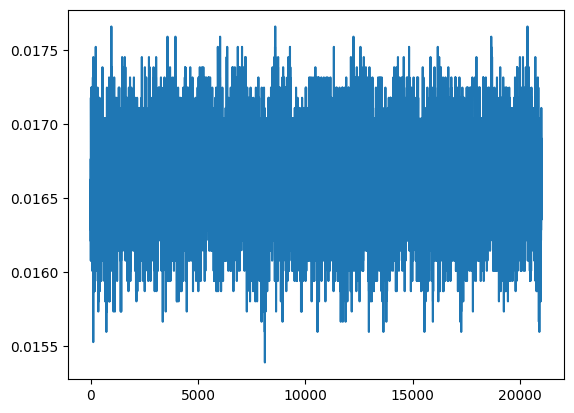

Decompressing file into memory...


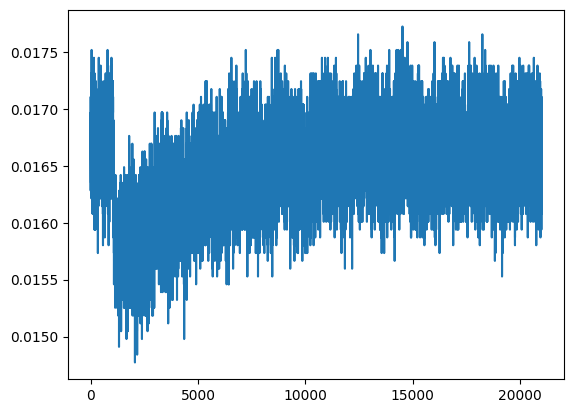

Decompressing file into memory...


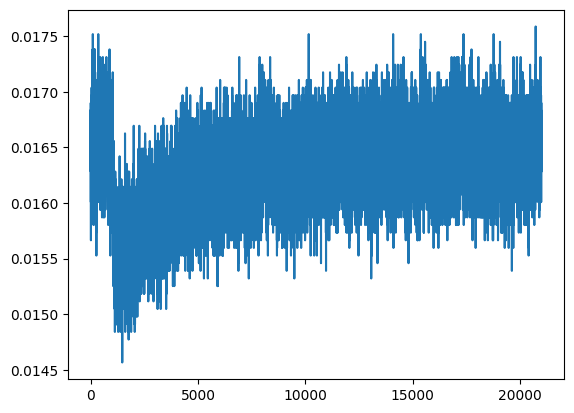

In [6]:
for file in files:
    compressed_file_io = drive.download_file_from_drive(svc, file['id'])

    # Decompress the HDF5 file and load it into memory
    print("Decompressing file into memory...")
    data = drive.decompress_hdf5_to_memory(compressed_file_io)
    T = np.linspace(0,len(data),len(data))
    plt.plot(T,data)
    plt.show()

It freakin works!!

In [7]:
from iminuit import minuit
from iminuit.cost import LeastSquares

In [8]:
len_fit = int(np.floor(len(data)/10))
pol_amp = np.polyfit(T[:len_fit], data[:len_fit], 2)
rms = np.sqrt(np.mean((np.polyval(pol_amp, T[:len_fit])-data[:len_fit])**2)) 

In [9]:
window_size = 80  # Size of the moving average window
cumsum = np.cumsum(data)
cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
moving_avg = cumsum[window_size - 1:] / window_size

In [10]:
from scipy.signal import savgol_filter

In [11]:
# Pad the moving average to match the length of the original signal
moving_avg = np.pad(moving_avg, (window_size - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))
window_length = 171  # Must be odd
polyorder = 3
sg_filtered_signal = savgol_filter(moving_avg, window_length, polyorder)

In [12]:
# Post-processing: Optional further smoothing
window_size = 5
smoothed_signal = np.convolve(sg_filtered_signal, np.ones(window_size)/window_size, mode='valid')

In [13]:
len_fit = int(np.floor(len(sg_filtered_signal)/10))
pol_amp = np.polyfit(T[:len_fit], sg_filtered_signal[:len_fit], 2)
rms = np.sqrt(np.mean((np.polyval(pol_amp, T[:len_fit])-sg_filtered_signal[:len_fit])**2)) 

In [14]:
def model(x,A,tau1,B,C):
    return -A*(x/tau1)*(np.exp(-(x+C)/tau1))+B

In [25]:
p0 = [0.00150,1.7e3,0.0165,-1000]

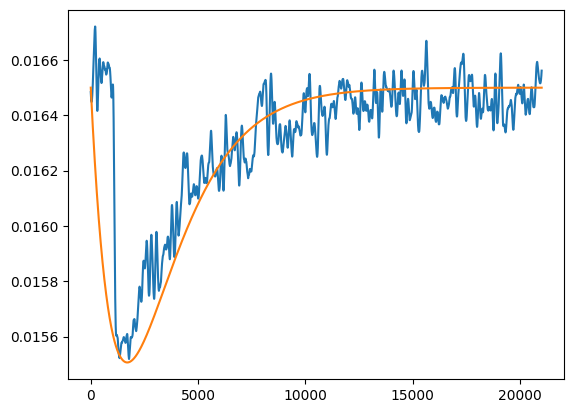

In [26]:
plt.plot(sg_filtered_signal)
plt.plot(T,model(T,*p0))

In [27]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [29]:
sig = LeastSquares(T,sg_filtered_signal,rms,model)
msig = Minuit(sig,*p0)
msig.migrad(iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6889 (χ²/ndof = 0.3)       │              Nfcn = 105              │
│ EDM = 5.64e-06 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  1.2e-3   │  0.5e-3   │            │            │         │         │       │
│ 1 │ tau1 │  2.138e3  │  0.016e3  │            │            │         │         │       │
│ 2 │ B    │16.4908e-3 │ 0.0023e-3 │            │            │         │         │       │
│ 3 │ C    │  -0.8e3   │   0.8e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────────────────────────────────┐
│      │            A         tau1            B            C │
├──────┼─────────────────────────────────────────────────────┤
│    A │     2.07e-07    104.11e-6       19e-12 360.45600e-3 │
│ tau1 │    104.11e-6          242 16.765729e-6       0.13e3 │
│    B │       19e-12 16.765729e-6     5.52e-12  8.670491e-6 │
│    C │ 360.45600e-3       0.13e3  8.670491e-6     6.29e+05 │
└──────┴─────────────────────────────────────────────────────┘

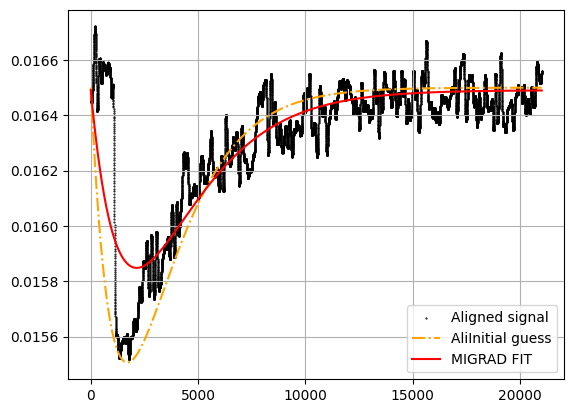

In [30]:
plt.scatter(T,sg_filtered_signal,marker='.',s=1,color='black',label='Aligned signal')
plt.plot(T,model(T,*p0),linestyle='-.',color='orange',label='AliInitial guess')
plt.plot(T,model(T,*msig.values),color='red',label='MIGRAD FIT')
plt.grid()
plt.legend()

In [31]:
msig.params

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  1.2e-3   │  0.5e-3   │            │            │         │         │       │
│ 1 │ tau1 │  2.138e3  │  0.016e3  │            │            │         │         │       │
│ 2 │ B    │16.4908e-3 │ 0.0023e-3 │            │            │         │         │       │
│ 3 │ C    │  -0.8e3   │   0.8e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [32]:
print(f'Fall time : {msig.values[1]*1e-8*1e6} micro sec')

Fall time : 21.37632483091685 micro sec
